In [1]:
%%time
import argparse
import numpy as np
import sys, os
import math
import logging
import time
import galsim
import galsim.roman as roman
import datetime
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import h5py
#import photerr
import seaborn as sns
from scipy.stats import gaussian_kde

CPU times: user 5.11 s, sys: 1.62 s, total: 6.73 s
Wall time: 30.2 s


In [2]:
use_filters = 'ZYJHFKW'
roman_filters = roman.getBandpasses(AB_zeropoint=True)

# Get the names of the ones we will use here.
filters = [filter_name for filter_name in roman_filters if filter_name[0] in use_filters]

filters_copy = filters.copy()
filters_copy[5] = filters_copy[6]
filters_copy[6] = filters[5]
filters = filters_copy

blue_limit, red_limit, eff_wave = np.zeros(7), np.zeros(7), np.zeros(7)
for i in range(len(filters)):

    bandpass = roman_filters[filters[i]]
    eff_wave[i] = bandpass.effective_wavelength
    blue_limit[i], red_limit[i] = bandpass.blue_limit, bandpass.red_limit
    sampling_rate = (eff_wave[i]/1e3)*7.9/10
    print(filters[i] + ': %.2f'%sampling_rate )

Z087: 0.69
Y106: 0.84
J129: 1.02
H158: 1.25
F184: 1.46
K213: 1.68
W146: 1.16


In [3]:
def get_roman_ErrModel(scenario, ext_type = 'auto', deep = False ):
    use_filters = ['Y106', 'J129', 'H158', 'F184', 'W146']
    mode, sky  = scenario_mode(scenario)
    if not deep:
        m5 = m5_scenario(mode, sky)
    else:
        m5 = m5_deep()
    if ext_type == 'point':
        for filter_ in use_filters:
            m5[filter_] += 1 
    err_model = photerr.RomanErrorModel(
        theta = {
            "Z087": 0.214,
            "Y106": 0.220,
            "J129": 0.231,
            "H158": 0.242,
            "F184": 0.253,
            "K213": 0.264,
            "W146": 0.238
        },
        m5 = m5,
        airmass=1, extendedType = ext_type#, decorrelate = True,
    )
    return err_model

In [4]:
def get_mags_avg(gal_props ,err_model, indx_seed = 9999, use_filters = None, point = False, recurse = True):
    obs_mags = {}
    true_mags = {}
    err_mags = {}
    if use_filters is None:
        use_filters = filters
    for filter_name in use_filters:
        #print(filter_name)
        rng = np.random.default_rng(indx_seed)
        band = roman_filters[filter_name]
        band_prop_b = gal_props[filter_name]
        if point is False:
            a_tot,b_tot, mag_true_tot = band_prop_b['a'], band_prop_b['b'], band_prop_b['mag_true']
            d = {'major':a_tot, 'minor': b_tot, filter_name:mag_true_tot }
        else:
            mag_true_tot = band_prop_b['mag_true']
            d = {filter_name:mag_true_tot }    
        df = pd.DataFrame(data=d)
        df_all_obs = err_model(df, random_state = rng)
        obs_mag, mag_err = df_all_obs[filter_name].to_numpy(), df_all_obs[filter_name + '_err'].to_numpy()
        
        
        obs_mag[obs_mag >= 100] = 100
        if point:
            obs_mag[obs_mag >= 100] = 30.5
        idx = np.where(obs_mag == np.inf)[0]
        if recurse:
            for i in idx:#range(len(mag_err)):
                if obs_mag[i] >= 100:
                    #print(i)
                    #mag_err[i] = 50
                    gal_props_test = {}
                    if point is False:
                        a_bulge,b_bulge, mag_true_bulge = np.array([a_tot[i]]), np.array([b_tot[i]]), np.array([mag_true_tot[i]])
                        gal_props_test[filter_name] = {'a': a_bulge, 'b': b_bulge, 'mag_true':mag_true_bulge }
                    else:
                        mag_true_bulge = np.array([mag_true_tot[i]])
                        gal_props_test[filter_name] = {'mag_true':mag_true_bulge }
                    true_mags_, obs_mags_, err_mags_ = get_mags_avg(gal_props_test, err_model,indx_seed = indx_seed+1, 
                                                                    use_filters = [filter_name], recurse = False)
                    mag_err[i] = err_mags_[filter_name][0]
                    obs_mag[i] = obs_mags_[filter_name][0]

        obs_mags[filter_name] = obs_mag
        err_mags[filter_name] = mag_err
        true_mags[filter_name] = mag_true_tot
    return true_mags, obs_mags, err_mags


In [5]:
def scenario_mode(scenario = 'A'):
    if scenario == 'A':
        return 'reference', 'dark'
    elif scenario == 'B':
        return 'fast', 'bright'
    elif scenario == 'C':
        return 'fast', 'bright'
    elif scenario == 'D':
        return 'fast', 'dark'
    elif scenario == 'E':
        return 'fast', 'bright'
    elif scenario == 'F':
        return 'fast', 'bright'
def m5_deep():
    m5 = {'Y106': 26.6, 'J129': 26.54, 'H158': 26.48, 'F184': 26 ,'K213': 25, 'W146': 26.7}
    return m5 

def m5_scenario(mode = 'reference', sky = 'dark'):
    if mode == 'reference':
        if sky == 'dark':
            m5 = {'Y106': 25.58, 'J129': 25.57, 'H158': 25.56, 'F184': 25.01 ,'K213': 23.96, 'W146': 26.2}
        if sky == 'bright':
            m5 = {'Y106': 25.32 ,'J129': 25.31 ,'H158': 25.31, 'F184': 24.85,  'K213': 23.94, 'W146': 26}
    elif mode == 'fast':
        if sky == 'dark':
            m5 = {'Y106': 25.10,  'J129': 25.09,  'H158': 25.08,  'F184': 24.53, 'K213': 23.67, 'W146': 25.8}
        if sky == 'bright':
            m5 = {'Y106': 24.92, 'J129': 24.91, 'H158': 24.91, 'F184': 24.42 ,'K213': 23.65, 'W146': 25.6}
    return m5 
def Hcut_SN18(scenario = 'A'):
    if scenario == 'A':
        return 24.96
    elif scenario == 'B':
        return 23.93
    elif scenario == 'C':
        return 24.31
    elif scenario == 'D':
        return 24.49
    elif scenario == 'E':
        return 24.31
    elif scenario == 'F':
        return 24.31
    

In [39]:
def plot_2d(arr1, arr2, arrc = None, arrc2 = None ,save = False):
    # Assuming `arr1` and `arr2` are already defined
    #random_indices = np.random.choice(np.arange(len(arr1)), 100000, replace = False)
    #arr1 = np.array(arr1)[random_indices]
    #arr2 = np.array(arr2)[random_indices]
    # Define the figure and grid layout
    fig = plt.figure(figsize=(9, 9))
    gs = fig.add_gridspec(4, 4, width_ratios=(7, 3, 0.2, 0.2), height_ratios=(3, 7, 0.2, 0.2), wspace=0.0, hspace=0.0)

    levels=[0.16, 0.5, 0.84, 1]
    # Main contour plot
    ax_main = fig.add_subplot(gs[1, 0])
    data = np.vstack([arr1, arr2])
    kde = gaussian_kde(data)(data)
    sns.kdeplot(x=arr1, y=arr2, fill=True, cmap='Blues', ax=ax_main, levels=levels, clip = ((0,3),(20,24.96)), gridsize = 100)
    if arrc is not None and arrc2 is not None:
        sns.kdeplot(x=arrc1, y=arrc2, fill=False, cmap='Reds', ax=ax_main, levels=levels, clip = ((0,3),(20,24.96)), gridsize = 100,linestyles='--', linewidths=4)
    ax_main.set_xlim(arr1.min(), arr1.max())
    ax_main.set_ylim(arr2.min(), arr2.max())
    ax_main.set_xlabel(r'Redshift', fontsize=24)
    ax_main.set_ylabel(r'H-band Magnitude', fontsize=24)
    ax_main.set_ylim (20,25.1)
    ax_main.tick_params(axis='both', which='major', labelsize=22)
    ax_main.set_xticks([0.5, 1, 1.5, 2, 2.5, 3])

    # Top histogram
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_main)
    ax_histx.hist(arr1, bins=30, color='grey', edgecolor='blue',histtype='step', density=False, range = (0,3), label = 'diffsky')
    if arrc is not None:
        ax_histx.hist(arrc1, bins=30, color='grey', edgecolor='red',histtype='step', density=False, ls = '--', range = (0,3), label = 'cosmoDC2')
    sns.kdeplot(arr1, ax=ax_histx, color='black')
    plt.setp(ax_histx.get_xticklabels(), visible=False)
    plt.setp(ax_histx.get_yticklabels(), visible=False)
    ax_histx.tick_params(axis='y', which='both', left=True, right=True, labelleft=False, labelright=False)
    #ax_histx.tick_params(axis='y', left=False)
    ax_histx.spines['right'].set_visible(True)
    ax_histx.spines['top'].set_visible(True)
    ax_histx.set_xlabel('')  # Remove x-axis label
    ax_histx.set_ylabel('')
    #ax_histx.set_ylim(0, 800)
    ax_histx.legend(frameon= False, fontsize = 18)

    # Right histogram
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_main)
    ax_histy.hist(arr2, bins=30, color='grey', edgecolor='blue',histtype='step', density=False, orientation='horizontal', range = (18,25))
    if arrc2 is not None:
        ax_histy.hist(arrc2, bins=30, color='grey', edgecolor='red',histtype='step', density=False, orientation='horizontal', ls = '--', range = (18,25))
    sns.kdeplot(arr2, ax=ax_histy, color='black', vertical=True)
    plt.setp(ax_histy.get_xticklabels(), visible=False)
    plt.setp(ax_histy.get_yticklabels(), visible=False)
    ax_histy.tick_params(axis='x', which='both', top=True, bottom=True, labelleft= False, labelright=False)
    ax_histy.tick_params(axis='y', which='both', left=True, right=False, labelleft= False, labelright=False)
    #ax_histy.tick_params(axis='x', bottom=False)
    ax_histy.spines['right'].set_visible(True)
    ax_histy.spines['top'].set_visible(True)
    ax_histy.set_xlabel('')  # Remove x-axis label
    ax_histy.set_ylabel('') 

    # Hide unnecessary plots
    fig.delaxes(fig.add_subplot(gs[0, 1]))  # Remove the top-right plot
    fig.delaxes(fig.add_subplot(gs[0, 2]))  # Remove the extra top space
    fig.delaxes(fig.add_subplot(gs[1, 2]))  # Remove the extra right space

    # Adjust the layout
    plt.tight_layout()
    if save:
        plt.savefig('PaperFigures/2dMagzHistogram.png', format='png', dpi=300,bbox_inches='tight')
    plt.show()

In [37]:
def plot_2d_color(arr1, arr2, arrc = None, arrc2 = None):
    # Assuming `arr1` and `arr2` are already defined
    #random_indices = np.random.choice(np.arange(len(arr1)), 100000, replace = False)
    #arr1 = np.array(arr1)[random_indices]
    #arr2 = np.array(arr2)[random_indices]
    # Define the figure and grid layout
    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(4, 4, width_ratios=(7, 3, 0.2, 0.2), height_ratios=(3, 7, 0.2, 0.2), wspace=0.0, hspace=0.0)

    levels=[0.16, 0.5, 0.84, 1]
    # Main contour plot
    ax_main = fig.add_subplot(gs[1, 0])
    data = np.vstack([arr1, arr2])
    kde = gaussian_kde(data)(data)
    sns.kdeplot(x=arr1, y=arr2, fill=True, cmap='Blues', ax=ax_main, levels=levels, gridsize = 100)
    if arrc is not None and arrc2 is not None:
        sns.kdeplot(x=arrc1, y=arrc2, fill=False, cmap='Reds', ax=ax_main, levels=levels, gridsize = 100,linestyles='--', linewidths=4)
    ax_main.set_xlim(arr1.min(), arr1.max())
    ax_main.set_ylim(arr2.min(), arr2.max())
    ax_main.set_xlabel(r'Redshift', fontsize=24)
    ax_main.set_ylabel(r'H-band Magnitude', fontsize=24)
    ax_main.set_ylim (-0.2,0.8)
    ax_main.tick_params(axis='both', which='major', labelsize=22)
    #ax_main.set_xticks([0.5, 1, 1.5, 2, 2.5, 3])

    # Top histogram
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_main)
    ax_histx.hist(arr1, bins=30, color='grey', edgecolor='blue',histtype='step', density=False, label = 'diffsky')
    if arrc is not None:
        ax_histx.hist(arrc1, bins=30, color='grey', edgecolor='red',histtype='step', density=False, ls = '--', label = 'cosmoDC2')
    sns.kdeplot(arr1, ax=ax_histx, color='black')
    plt.setp(ax_histx.get_xticklabels(), visible=False)
    plt.setp(ax_histx.get_yticklabels(), visible=False)
    ax_histx.tick_params(axis='y', which='both', left=True, right=True, labelleft=False, labelright=False)
    #ax_histx.tick_params(axis='y', left=False)
    ax_histx.spines['right'].set_visible(True)
    ax_histx.spines['top'].set_visible(True)
    ax_histx.set_xlabel('')  # Remove x-axis label
    ax_histx.set_ylabel('')
    #ax_histx.set_ylim(0, 800)
    ax_histx.legend(frameon= False, fontsize = 18)


    # Hide unnecessary plots
    fig.delaxes(fig.add_subplot(gs[0, 1]))  # Remove the top-right plot
    fig.delaxes(fig.add_subplot(gs[0, 2]))  # Remove the extra top space
    fig.delaxes(fig.add_subplot(gs[1, 2]))  # Remove the extra right space

    # Adjust the layout
    plt.tight_layout()
    plt.show()

In [9]:
def get_sat_mag_lim(filter_name):
    if filter_name == 'Y106':
        mag_min, mag_max = 17.9, 21.2
    if filter_name == 'J129':
        mag_min, mag_max = 17.9, 21.2
    if filter_name == 'H158':
        mag_min, mag_max = 17.9, 21.2
    if filter_name == 'F184':
        mag_min, mag_max = 17.2, 20.8
    return mag_min

In [10]:
def get_color(mags, cut = None):
    color = {}
    if cut is None:
        cut = np.ones(len(mags['Y106']), dtype = bool)
    color['Y-J'] = mags['Y106'][cut]- mags['J129'][cut]
    color['J-H'] = mags['J129'][cut]- mags['H158'][cut]
    color['H-F'] = mags['H158'][cut]- mags['F184'][cut]
    return color

## diffsky PDR 10307

In [79]:
data_dir = '/hildafs/projects/phy200017p/share/euclid_sim/input_catalog/roman_rubin_cats_v1.1.2_faint/'

## galaxy catalog
gal_data = pd.read_parquet(data_dir + 'galaxy_10307.parquet', engine='pyarrow')
flux_data = pd.read_parquet(data_dir +'galaxy_flux_10307.parquet', engine='pyarrow')

z = np.array(gal_data['redshift'])
zp=roman.getBandpasses()['H158'].zeropoint
mag=-2.5*np.log10(flux_data['roman_flux_H158'])+zp
list_len = len(flux_data)


filename = data_dir +"galaxy_sed_10307.hdf5"
f = h5py.File(filename, "r")
data = f['galaxy']
wave_list = f['meta']['wave_list'][()]



In [80]:
pickle_out = open("Gal_props_catnoise/gal_props_approx_diffsky_10307","rb")
gal_props_10307 = pickle.load(pickle_out)
pickle_out.close()

In [81]:
len(z), len(gal_props_10307['galaxy_id'])

(3561877, 3561877)

In [10]:
import healpy as hp
hp.nside2pixarea(32, degrees = True) 

3.357174580844667

In [82]:
true_mags, obs_mags, err_mags = {}, {}, {}
use_filters = ['Y106', 'J129', 'H158', 'F184', 'W146']
scenarios = ['A', 'B', 'C', 'D', 'E', 'F']
for scenario in scenarios:
    print(scenario)
    err_model_scenario = get_roman_ErrModel(scenario, deep = False)
    true_mags[scenario], obs_mags[scenario], err_mags[scenario] = get_mags_avg(gal_props_10307,
                                                                                err_model_scenario,
                                                                                use_filters =use_filters,  
                                                                                indx_seed = 1234, recurse = False)    

A
B
C
D
E
F


In [83]:
roman_mag_info = {'gal_id':gal_props_10307['galaxy_id'],'z':z, 'true_mag':true_mags,
                  'obs_mag':obs_mags, 'err_mag':err_mags}
pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_diffsky_10307","wb")
pickle.dump(roman_mag_info, pickle_out)
pickle_out.close()

In [58]:
pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_diffsky_10307","rb")
roman_mag_info = pickle.load(pickle_out)
pickle_out.close()

In [84]:
num_gal = 10000
gal_ids = gal_props_10307['galaxy_id']
true_mags_cut, obs_mags_cut, err_mags_cut = {}, {}, {}
#gal_ids_cut,z_cut = {}, {}
#final_cut_,random_indices_ = {}, {}
scenarios = ['A', 'B', 'C', 'D', 'E', 'F']

SN_cut = obs_mags['A']['H158'] < Hcut_SN18('A') 
Y_cut = obs_mags['A']['Y106'] < 100
J_cut = obs_mags['A']['J129'] < 100
F_cut = obs_mags['A']['F184'] < 100
W_cut = obs_mags['A']['W146'] < 100
fail_cut = np.logical_and(Y_cut, J_cut)
fail_cut = np.logical_and(fail_cut, F_cut)
fail_cut = np.logical_and(fail_cut, W_cut)
final_cut = np.logical_and(fail_cut, SN_cut)
np.random.seed(1234)
random_indices = np.random.choice(np.arange(len(gal_ids[final_cut])), num_gal, replace = False)
for scenario in scenarios:
    true_mags_cut[scenario] = {}
    obs_mags_cut[scenario] = {}
    err_mags_cut[scenario] = {}
    for filter_ in use_filters:
        true_mags_cut[scenario][filter_] = true_mags[scenario][filter_][final_cut][random_indices]
        obs_mags_cut[scenario][filter_] = obs_mags[scenario][filter_][final_cut][random_indices]
        err_mags_cut[scenario][filter_] = err_mags[scenario][filter_][final_cut][random_indices]
gal_ids_cut = gal_ids[final_cut][random_indices]
z_cut = z[final_cut][random_indices]
#final_cut_[scenario] = final_cut
#random_indices_[scenario] = random_indices

In [85]:
roman_mag_info = {'gal_id':gal_ids_cut,'z':z_cut, 'true_mag':true_mags_cut,'obs_mag':obs_mags_cut,
                   'err_mag':err_mags_cut, 'cut':final_cut, 'rand_ind': random_indices }
pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_diffsky_10307_10000cut","wb")
pickle.dump(roman_mag_info, pickle_out)
pickle_out.close()

### stellar catalog

In [145]:
lst_files = os.listdir('stellar_SED/')
lst_files = [s for s in lst_files if s[12] == '1']
comb_star_data = pd.read_parquet('stellar_SED/' + lst_files[0], engine='pyarrow')
for file in lst_files[1:]:
    temp_star_data = pd.read_parquet('stellar_SED/' + file, engine='pyarrow')
    comb_star_data = pd.concat([comb_star_data,temp_star_data], ignore_index=True)
    
kurucz_mask = np.zeros(len(comb_star_data), dtype = bool)
for i in range(len(comb_star_data)):
    sed_file = comb_star_data['sed_filepath']
    if sed_file[i][8] == 'k':
        kurucz_mask[i] = True
        
star_data= comb_star_data[kurucz_mask][:400000]
stellar_root = '/hildafs/projects/phy200017p/share/tq_share/'
stellar_dir = ['gizis_SED' , 'kurucz' , 'mlt' , 'old_mlt' , 'phoSimMLT' , 'wDs']

In [253]:
#star_data

In [114]:
def flux2mag(flux, filters):
    zp = {}
    mag = {}
    for j in range(len(filters)):
        bp = roman_filters[filters[j]]
        zp = bp.zeropoint
        mag[filters[j]] = -2.5*np.log10(flux[filters[j]]) + zp  
    return mag

In [112]:
roman_stars_flux = {}
for filter_name in filters:
    pickle_out = open("Star_Fluxes/Stars_Flux_10000Gal_" + filter_name ,"rb")
    roman_stars_flux[filter_name] = pickle.load(pickle_out)
    pickle_out.close()

In [118]:
star_mags = flux2mag(roman_stars_flux, use_filters)
star_props = {}
for filter_name in use_filters:
    star_props[filter_name] = {'mag_true':star_mags[filter_name] }

In [162]:
true_star_mags, obs_star_mags, err_star_mags = {}, {}, {}
snr = {}
scenarios = ['A', 'B', 'C', 'D', 'E', 'F']
for scenario in scenarios:
    err_model_scenario = get_roman_ErrModel(scenario,deep = False, ext_type = 'point')
    true_star_mags[scenario], obs_star_mags[scenario], err_star_mags[scenario] = get_mags_avg(star_props,
                                                                                err_model_scenario,
                                                                                use_filters =use_filters,  
                                                                                indx_seed = 1234, point = True)
    snr[scenario] = {}
    for filt_ in use_filters:
        snr[scenario][filt_] = 1 / (10 ** (err_star_mags[scenario][filt_]/ 2.5) - 1) 


In [165]:
roman_mag_info = {'star_id':np.array(star_data['id']), 'true_mag':true_star_mags,
                  'obs_mag':obs_star_mags, 'err_mag':err_star_mags, 'snr':snr }
pickle_out = open("Gal_props_catnoise/roman_star_obsmags_diffsky","wb")
pickle.dump(roman_mag_info, pickle_out)
pickle_out.close()

## deep field

In [86]:
pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_diffsky_10307_10000cut","rb")
roman_mag_info = pickle.load(pickle_out)
pickle_out.close()
test_ids = roman_mag_info['gal_id']

In [87]:
#gal_data[roman_mag_info['cut']].reset_index(drop=True).iloc[roman_mag_info['rand_ind']]['redshift']

In [88]:
true_mags, obs_mags, err_mags = {}, {}, {}
use_filters = ['Y106', 'J129', 'H158', 'F184', 'W146']
scenarios = ['A', 'B', 'C', 'D', 'E', 'F']
for scenario in scenarios:
    print(scenario)
    err_model_scenario = get_roman_ErrModel(scenario, deep = True)
    true_mags[scenario], obs_mags[scenario], err_mags[scenario] = get_mags_avg(gal_props_10307,
                                                                                err_model_scenario,
                                                                                use_filters =use_filters,  
                                                                                indx_seed = 1234, recurse = False)    

A
B
C
D
E
F


In [89]:
roman_mag_info = {'gal_id':gal_props_10307['galaxy_id'],'z':z, 'true_mag':true_mags,
                  'obs_mag':obs_mags, 'err_mag':err_mags}
pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_diffsky_10307_deep","wb")
pickle.dump(roman_mag_info, pickle_out)
pickle_out.close()

In [94]:
num_gal = 40000
gal_ids = gal_props_10307['galaxy_id']
true_mags_cut, obs_mags_cut, err_mags_cut = {}, {}, {}
gal_ids_cut, z_cut = {}, {}
final_cut_, random_indices_ = {}, {}
scenarios = ['A', 'B', 'C', 'D', 'E', 'F']
for scenario in scenarios:
    true_mags_cut[scenario] = {}
    obs_mags_cut[scenario] = {}
    err_mags_cut[scenario] = {}
    gal_ids_cut[scenario] = {}
    z_cut[scenario] = {}
    SN_cut = obs_mags[scenario]['H158'] < Hcut_SN18(scenario) 
    Y_cut = obs_mags[scenario]['Y106'] < 100
    J_cut = obs_mags[scenario]['J129'] < 100
    F_cut = obs_mags[scenario]['F184'] < 100
    W_cut = obs_mags[scenario]['W146'] < 100
    fail_cut = np.logical_and(Y_cut, J_cut)
    fail_cut = np.logical_and(fail_cut, F_cut)
    fail_cut = np.logical_and(fail_cut, W_cut)
    final_cut = np.logical_and(fail_cut, SN_cut)
    id_cut = ~(np.in1d(gal_ids, test_ids))
    final_cut = np.logical_and(final_cut, id_cut)
    np.random.seed(1234)
    random_indices = np.random.choice(np.arange(len(gal_ids[final_cut])), num_gal, replace = False)
    for filter_ in use_filters:
        true_mags_cut[scenario][filter_] = true_mags[scenario][filter_][final_cut][random_indices]
        obs_mags_cut[scenario][filter_] = obs_mags[scenario][filter_][final_cut][random_indices]
        err_mags_cut[scenario][filter_] = err_mags[scenario][filter_][final_cut][random_indices]
    gal_ids_cut[scenario] = gal_ids[final_cut][random_indices]
    z_cut[scenario] = z[final_cut][random_indices]
    final_cut_[scenario] = final_cut
    random_indices_[scenario] = random_indices

In [98]:
roman_mag_info = {'gal_id':gal_ids_cut,'z':z_cut, 'true_mag':true_mags_cut,'obs_mag':obs_mags_cut,
                   'err_mag':err_mags_cut, 'cut':final_cut_, 'rand_ind': random_indices_ }
pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_diffsky_10307_deep_10000cut","wb")
pickle.dump(roman_mag_info, pickle_out)
pickle_out.close()

## CosmoDC2

In [55]:
data_dir = 'cosmoDC2/'
df_galinfo = pd.read_parquet(data_dir + 'galaxy_10067_subset_fullsed.parquet', engine='pyarrow')
df_flux = pd.read_parquet(data_dir +'galaxy_flux_10067_subset_fullsed.parquet', engine='pyarrow')

In [19]:
#data_dir = 'cosmoDC2/'
#df_galinfo = pd.read_parquet(data_dir + 'galaxy_10067.parquet', engine='pyarrow')
#df_flux = pd.read_parquet(data_dir +'galaxy_flux_10067.parquet', engine='pyarrow')

In [58]:
z = np.array(df_galinfo['redshift'])
#gal_props_cosmodc2['galaxy_id'] = np.array(df_galinfo['id'])

In [11]:
gal_props_cosmodc2 = {}
use_filters = ['Y106', 'J129', 'H158', 'F184', 'W146']
#num_g = 60000
for filter_ in use_filters:
    zp=roman.getBandpasses()[filter_].zeropoint
    mag_f =-2.5*np.log10(np.array(df_flux['roman_flux_' + filter_]))+zp
    gal_props_cosmodc2[filter_] = {'a': np.array(df_galinfo['semiMajorAxis']), 
                               'b':np.array(df_galinfo['semiMinorAxis']), 'mag_true':mag_f}
gal_props_cosmodc2['galaxy_id'] = np.array(df_galinfo['id'])

In [12]:
pickle_out = open("Gal_props_catnoise/gal_props_approx_cosmodc2_10067","wb")
pickle.dump(gal_props_cosmodc2, pickle_out)
pickle_out.close()

In [13]:
true_mags, obs_mags, err_mags = {}, {}, {}
use_filters = ['Y106', 'J129', 'H158', 'F184', 'W146']
scenarios = ['A', 'B', 'C', 'D', 'E', 'F']
for scenario in scenarios:
    print(scenario)
    err_model_scenario = get_roman_ErrModel(scenario, deep = False)
    true_mags[scenario], obs_mags[scenario], err_mags[scenario] = get_mags_avg(gal_props_cosmodc2,
                                                                                err_model_scenario,
                                                                                use_filters =use_filters,  
                                                                                indx_seed = 1234, recurse = False)    

A
B
C
D
E
F


In [14]:
roman_mag_info = {'gal_id':gal_props_cosmodc2['galaxy_id'],'z':z, 'true_mag':true_mags,
                  'obs_mag':obs_mags, 'err_mag':err_mags}
pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_cosmodc2_10067","wb")
pickle.dump(roman_mag_info, pickle_out)
pickle_out.close()

In [15]:
num_gal = 10000
gal_ids = gal_props_cosmodc2['galaxy_id']
true_mags_cut, obs_mags_cut, err_mags_cut = {}, {}, {}
#gal_ids_cut,z_cut = {}, {}
#final_cut_,random_indices_ = {}, {}
scenarios = ['A', 'B', 'C', 'D', 'E', 'F']

SN_cut = obs_mags['A']['H158'] < Hcut_SN18('A') 
Y_cut = obs_mags['A']['Y106'] < 100
J_cut = obs_mags['A']['J129'] < 100
F_cut = obs_mags['A']['F184'] < 100
W_cut = obs_mags['A']['W146'] < 100
fail_cut = np.logical_and(Y_cut, J_cut)
fail_cut = np.logical_and(fail_cut, F_cut)
fail_cut = np.logical_and(fail_cut, W_cut)
final_cut = np.logical_and(fail_cut, SN_cut)
np.random.seed(1234)
random_indices = np.random.choice(np.arange(len(gal_ids[final_cut])), num_gal, replace = False)
for scenario in scenarios:
    true_mags_cut[scenario] = {}
    obs_mags_cut[scenario] = {}
    err_mags_cut[scenario] = {}
    for filter_ in use_filters:
        true_mags_cut[scenario][filter_] = true_mags[scenario][filter_][final_cut][random_indices]
        obs_mags_cut[scenario][filter_] = obs_mags[scenario][filter_][final_cut][random_indices]
        err_mags_cut[scenario][filter_] = err_mags[scenario][filter_][final_cut][random_indices]
gal_ids_cut = gal_ids[final_cut][random_indices]
z_cut = z[final_cut][random_indices]


In [16]:
roman_mag_info = {'gal_id':gal_ids_cut,'z':z_cut, 'true_mag':true_mags_cut,'obs_mag':obs_mags_cut,
                   'err_mag':err_mags_cut, 'cut':final_cut, 'rand_ind': random_indices }
pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_cosmodc2_10067_10000cut","wb")
pickle.dump(roman_mag_info, pickle_out)
pickle_out.close()

### deep field

In [18]:
pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_cosmodc2_10067_10000cut","rb")
roman_mag_info = pickle.load(pickle_out)
pickle_out.close()
test_ids = roman_mag_info['gal_id']

pickle_out = open("Gal_props_catnoise/gal_props_approx_cosmodc2_10067","rb")
gal_props_cosmodc2 = pickle.load(pickle_out)
pickle_out.close()


In [19]:
#gal_data[roman_mag_info['cut']].reset_index(drop=True).iloc[roman_mag_info['rand_ind']]['redshift']

In [20]:
true_mags, obs_mags, err_mags = {}, {}, {}
use_filters = ['Y106', 'J129', 'H158', 'F184', 'W146']
scenarios = ['A', 'B', 'C', 'D', 'E', 'F']
for scenario in scenarios:
    print(scenario)
    err_model_scenario = get_roman_ErrModel(scenario, deep = True)
    true_mags[scenario], obs_mags[scenario], err_mags[scenario] = get_mags_avg(gal_props_cosmodc2,
                                                                                err_model_scenario,
                                                                                use_filters =use_filters,  
                                                                                indx_seed = 1234, recurse = False)    

A
B
C
D
E
F


In [21]:
roman_mag_info = {'gal_id':gal_props_cosmodc2['galaxy_id'],'z':z, 'true_mag':true_mags,
                  'obs_mag':obs_mags, 'err_mag':err_mags}
pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_cosmodc2_10067_deep","wb")
pickle.dump(roman_mag_info, pickle_out)
pickle_out.close()

In [22]:
num_gal = 40000
gal_ids = gal_props_cosmodc2['galaxy_id']
true_mags_cut, obs_mags_cut, err_mags_cut = {}, {}, {}
gal_ids_cut, z_cut = {}, {}
final_cut_, random_indices_ = {}, {}
scenarios = ['A', 'B', 'C', 'D', 'E', 'F']
for scenario in scenarios:
    true_mags_cut[scenario] = {}
    obs_mags_cut[scenario] = {}
    err_mags_cut[scenario] = {}
    gal_ids_cut[scenario] = {}
    z_cut[scenario] = {}
    SN_cut = obs_mags[scenario]['H158'] < Hcut_SN18(scenario) 
    Y_cut = obs_mags[scenario]['Y106'] < 100
    J_cut = obs_mags[scenario]['J129'] < 100
    F_cut = obs_mags[scenario]['F184'] < 100
    W_cut = obs_mags[scenario]['W146'] < 100
    fail_cut = np.logical_and(Y_cut, J_cut)
    fail_cut = np.logical_and(fail_cut, F_cut)
    fail_cut = np.logical_and(fail_cut, W_cut)
    final_cut = np.logical_and(fail_cut, SN_cut)
    id_cut = ~(np.in1d(gal_ids, test_ids))
    final_cut = np.logical_and(final_cut, id_cut)
    np.random.seed(1234)
    random_indices = np.random.choice(np.arange(len(gal_ids[final_cut])), num_gal, replace = False)
    for filter_ in use_filters:
        true_mags_cut[scenario][filter_] = true_mags[scenario][filter_][final_cut][random_indices]
        obs_mags_cut[scenario][filter_] = obs_mags[scenario][filter_][final_cut][random_indices]
        err_mags_cut[scenario][filter_] = err_mags[scenario][filter_][final_cut][random_indices]
    gal_ids_cut[scenario] = gal_ids[final_cut][random_indices]
    z_cut[scenario] = z[final_cut][random_indices]
    final_cut_[scenario] = final_cut
    random_indices_[scenario] = random_indices

In [23]:
roman_mag_info = {'gal_id':gal_ids_cut,'z':z_cut, 'true_mag':true_mags_cut,'obs_mag':obs_mags_cut,
                   'err_mag':err_mags_cut, 'cut':final_cut_, 'rand_ind': random_indices_ }
pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_cosmodc2_10067_deep_10000cut","wb")
pickle.dump(roman_mag_info, pickle_out)
pickle_out.close()

### Joint plot diffsky + cosmodc2

In [11]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

#mpl.rcParams['font.family']='serif'
#cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
#mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext']=True

from matplotlib import rcParams
rcParams.update({'font.family': 'serif', 'mathtext.fontset': 'dejavuserif',
                 'font.size': 12, 'text.latex.preamble': r"\usepackage{amsmath}",
                 'xtick.major.pad': 2, 'ytick.major.pad': 2, 'xtick.major.size': 6, 'ytick.major.size': 6,
                 'xtick.minor.size': 3, 'ytick.minor.size': 3, 'axes.linewidth': 2, 'axes.labelpad': 1})

In [12]:
pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_diffsky_10307_10000cut","rb")
roman_mag_info = pickle.load(pickle_out)
pickle_out.close()
obs_mags_cut = roman_mag_info['obs_mag']
z_cut = roman_mag_info['z']

pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_cosmodc2_10067_10000cut","rb")
roman_mag_info = pickle.load(pickle_out)
pickle_out.close()
obs_mags_cut_cd2 = roman_mag_info['obs_mag']
z_cut_cd2 = roman_mag_info['z']



pickle_out = open("Gal_props_catnoise/roman_star_obsmags_diffsky","rb")
roman_mag_info = pickle.load(pickle_out)
pickle_out.close()
obs_star_mags = roman_mag_info['obs_mag']['A']
true_star_mags = roman_mag_info['true_mag']['A']
snr_stars = roman_mag_info['snr']['A']

In [19]:
np.linspace(0.05, 1, 4)

array([0.05      , 0.36666667, 0.68333333, 1.        ])

/tmp/ipykernel_3351977/586522284.py:48: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(arr2, ax=ax_histy, color='black', vertical=True)


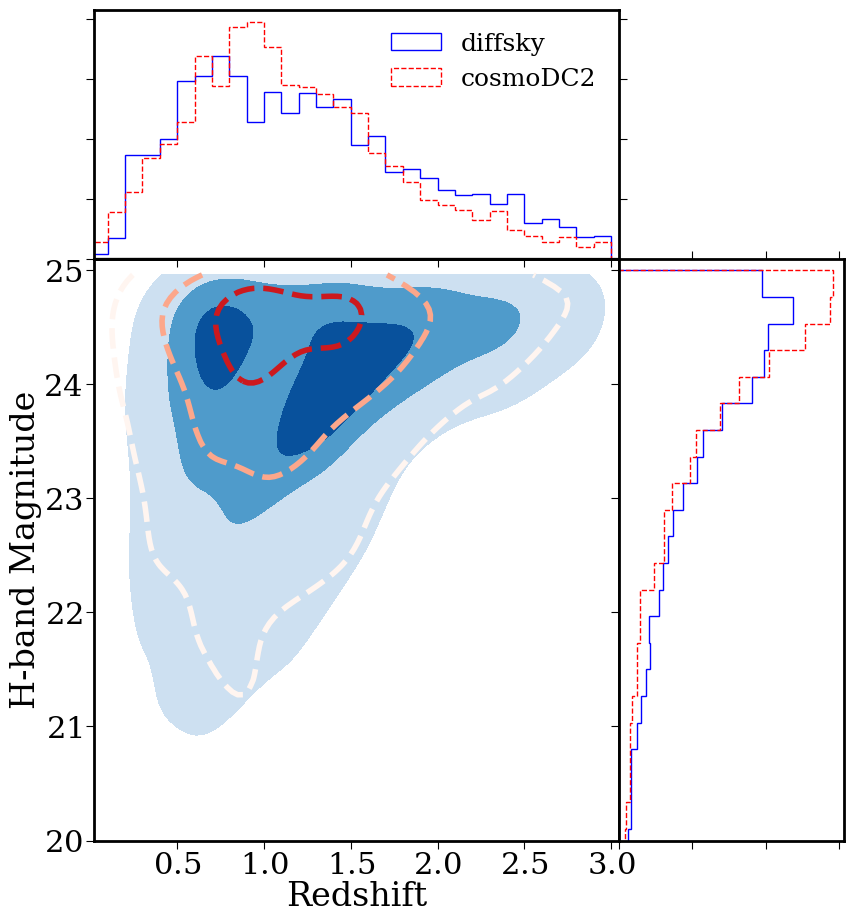

In [40]:
# levels=[ 
arr1 = z_cut.copy()
arr2 = obs_mags_cut['A']['H158'].copy()

arrc1 = z_cut_cd2.copy()
arrc2 = obs_mags_cut_cd2['A']['H158'].copy()
plot_2d(arr1, arr2, arrc1 , arrc2, save =True)

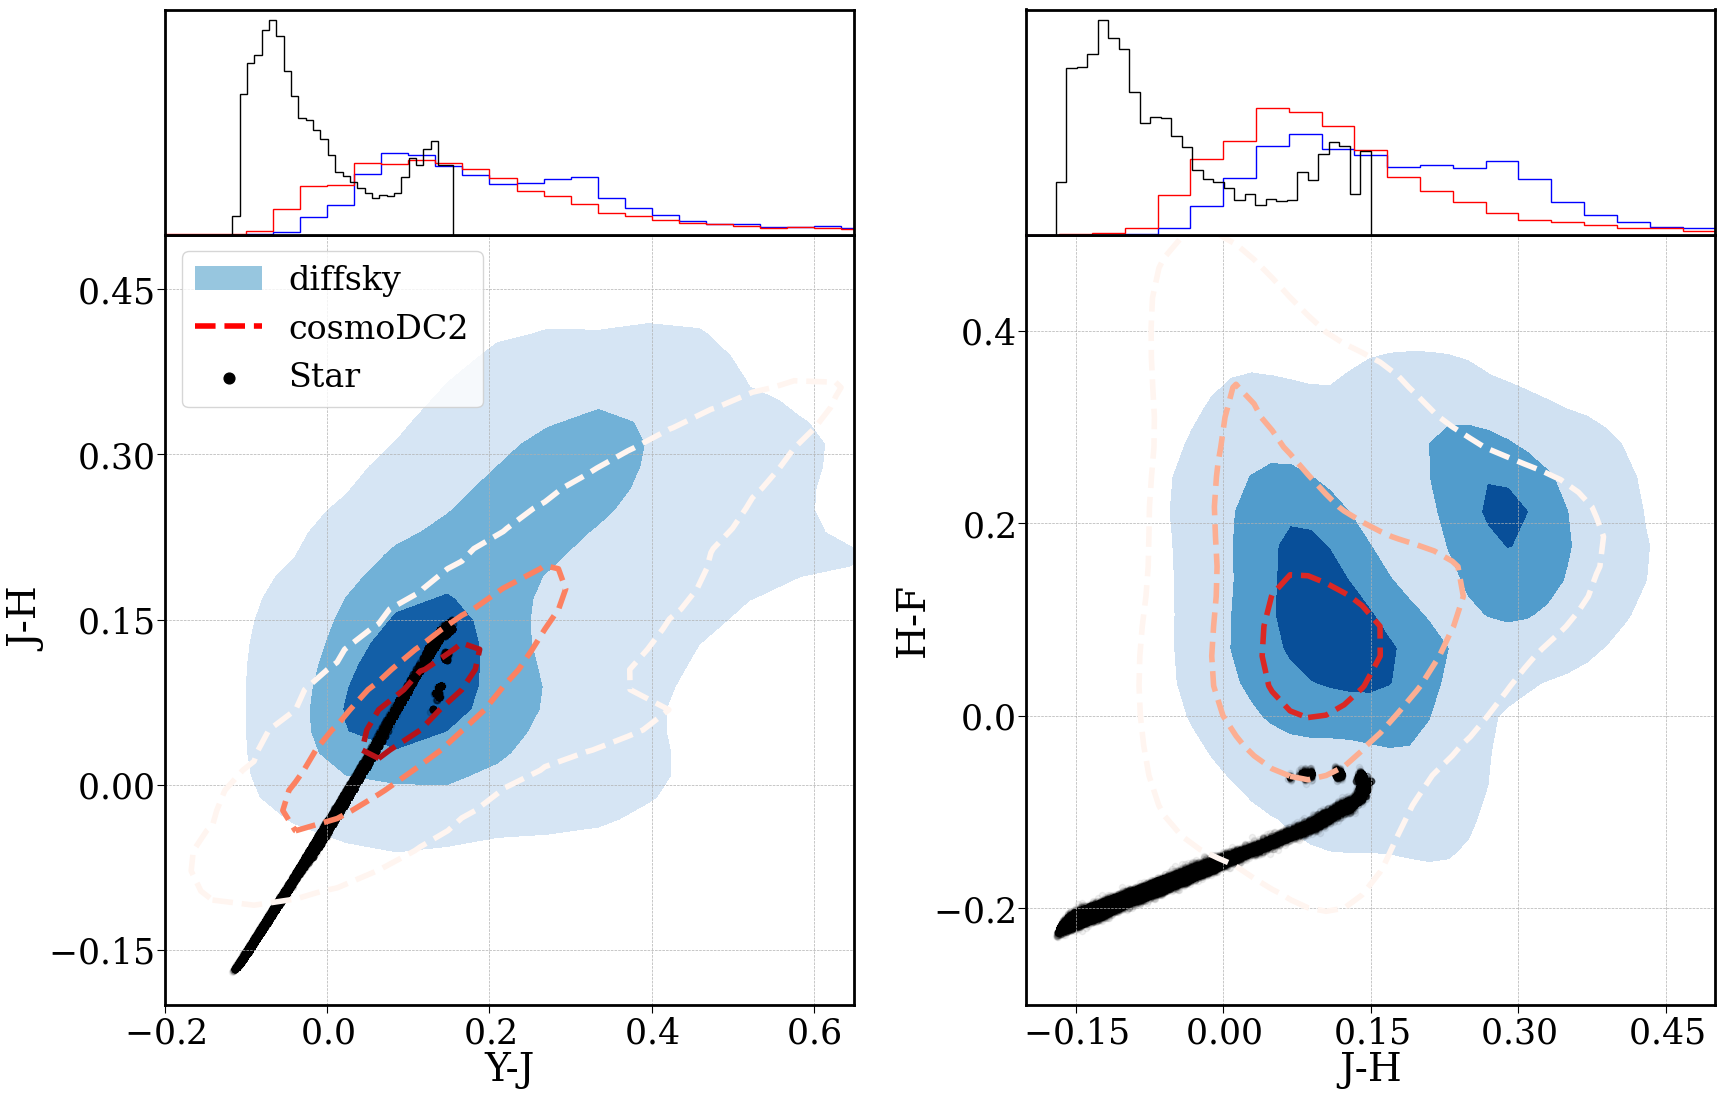

In [43]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the figure and the axes
fig, axs = plt.subplots(figsize=(20, 10), nrows=1, ncols=2, sharex=False, sharey=False)
fig.subplots_adjust(wspace=0.25, hspace=0.3)

# Create additional axes for the histograms (placed on top of the existing axes)
# Adjust the position of these axes to appear above the main plots
hist_axs = [fig.add_axes([ax.get_position().x0, ax.get_position().y1, ax.get_position().width, 0.225]) for ax in axs]

# Flatten the axs for easy iteration
axs = axs.flatten()
hist_axs = hist_axs  # Flatten hist_axs list as well

titles = ['Y-J', 'J-H', 'H-F']

# Loop through and plot the scatter plots and histograms
for i in range(2):
    filt = titles[i]
    filt2 = titles[i + 1]
    
    # Set plot labels and titles
    axs[i].set_xlabel(titles[i], fontsize=28)
    axs[i].set_ylabel(titles[i + 1], fontsize=28)
    if filt2 == 'K213':
        filt = 'H158'
        filt2 = 'W146'
        axs[i].set_xlabel('H-F', fontsize=24)
    
    # 2D KDE plot
    levels=[0.16, 0.5, 0.84, 1]
    sns.kdeplot(x=gal_color[filt], y=gal_color[filt2], fill=True, cmap='Blues', ax=axs[i], levels=levels, gridsize=100, alpha=1, label='Galaxy-diffsky', legend=True)
    sns.kdeplot(x=gal_color_cd2[filt], y=gal_color_cd2[filt2], fill=False, cmap='Reds', ax=axs[i], levels=levels, gridsize=100, linestyles='--', linewidths=4)
    
    # Scatter plot for stars
    axs[i].scatter(star_color[filt], star_color[filt2], color='black', alpha=0.05, s=20)
    
    # Plotting histograms above each plot (adjust y-limits and ticks)
    hist_axs[i].hist(gal_color[filt], bins=30, color='grey', edgecolor='blue',histtype='step',range = (-0.2, 0.8), density=True)
    hist_axs[i].hist(gal_color_cd2[filt], bins=30, color='grey', edgecolor='red',histtype='step',range = (-0.2, 0.8), density=True)
    hist_axs[i].hist(star_color[filt], bins=30, color='grey', edgecolor='black',histtype='step', density=True)
    hist_axs[i].set_xlim(axs[i].get_xlim())  # Make sure the x-limits match the 2D plot
    #hist_axs[i].set_ylim([0, 3000])  # Adjust the y-limits as needed for the histogram appearance
    hist_axs[i].set_yticklabels([])  # Remove the y-axis labels from the histogram
    hist_axs[i].tick_params(axis='x', labelsize=20)  # Optional: set x-axis label size for histograms
    hist_axs[i].tick_params(axis='y', left=False)  # Optional: remove y-axis ticks for histogram
    hist_axs[i].set_xticks([])  # Remove x-axis ticks from the histogram

    # Formatting for the main plot
    axs[i].tick_params(axis='both', which='major', labelsize=25)
    axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(5))

# Add legend and labels to the first plot
axs[0].scatter(-10, -10, color='C0', s=60, label='Galaxy-diffsky')
axs[0].scatter(-10, -10, color='red', s=60, label='Galaxy-cosmoDC2')
axs[0].scatter(-10, -10, color='black', s=60, label='Star')
handles = [mpatches.Patch(facecolor=plt.cm.Blues(100), label="diffsky"),
           Line2D([0], [0], color='red', ls='--', lw=4, label="cosmoDC2"),
           axs[0].scatter([], [], color='black', label="Star", s=60)]
axs[0].legend(handles=handles, loc='upper left', fontsize=24)

# Set axis limits
axs[0].set_xlim(-0.2, 0.65)
axs[0].set_ylim(-0.2, 0.5)

axs[1].set_xlim(-0.2, 0.5)
axs[1].set_ylim(-0.3, 0.5)

hist_axs[0].set_xlim(-0.2, 0.65)
#hist_axs[0].set_ylim(-0.2, 0.8)

hist_axs[1].set_xlim(-0.2, 0.5)
#hist_axs[1].set_ylim(-0.4, 0.6)


save = True
if save:
    plt.savefig('PaperFigures/ColorColorSimp.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

## SED removal

In [9]:
data_dir = 'cosmoDC2/'
df_galinfo = pd.read_parquet(data_dir + 'galaxy_10067_subset_fullsed.parquet', engine='pyarrow')
df_flux = pd.read_parquet(data_dir +'galaxy_flux_10067_subset_fullsed.parquet', engine='pyarrow')

In [10]:
#data_dir = 'cosmoDC2/'
#df_galinfo = pd.read_parquet(data_dir + 'galaxy_10067.parquet', engine='pyarrow')
#df_flux = pd.read_parquet(data_dir +'galaxy_flux_10067.parquet', engine='pyarrow')

In [11]:
z = np.array(df_galinfo['redshift'])
#gal_props_cosmodc2['galaxy_id'] = np.array(df_galinfo['id'])

In [12]:
gal_ids_string = np.array(df_galinfo['id']).astype(str)

In [13]:
len(z)

1000000

In [17]:
## read SED 
import gzip
filename = 'cosmoDC2/' +"sed_fit_10067.h5"
f = h5py.File(filename, "r")
gal_id = f['galaxy_id'][()].astype(str)
disk_sed_idx = f['disk_sed'][()]
bulge_sed_idx = f['bulge_sed'][()]
disk_sed_name = f['sed_names'][()][disk_sed_idx]
bulge_sed_name = f['sed_names'][()][bulge_sed_idx]
disk_magnorm = f['disk_magnorm'][()][3]
bulge_magnorm = f['bulge_magnorm'][()][3]

disk_sed_name = np.array([s.decode('utf-8') for s in disk_sed_name])
bulge_sed_name = np.array([s.decode('utf-8') for s in bulge_sed_name])

#disk_magnorm[disk_magnorm == np.inf] = 200
#bulge_magnorm[bulge_magnorm == np.inf] = 200

disk_dict = dict(zip(gal_id, disk_sed_name))
bulge_dict = dict(zip(gal_id, bulge_sed_name))
disk_dict_magnorm = dict(zip(gal_id, disk_magnorm))
bulge_dict_magnorm = dict(zip(gal_id, bulge_magnorm ))
sed_dict = {}
sed_dict['disk_sed'] = disk_dict
sed_dict['bulge_sed'] = bulge_dict
sed_dict['disk_magnorm'] = disk_dict_magnorm
sed_dict['bulge_magnorm'] = bulge_dict_magnorm

def get_galSED(file_name):
    with gzip.open(file_name, 'rb') as f:
        file_content = f.read()
    # Split the content by lines
    lines = file_content.splitlines()

    # Extract the data lines (skip the first line which is the header)
    data_lines = lines[1:]

    # Create a pandas DataFrame from the data lines
    # Use a space as the delimiter (split each line into two columns)
    data = [line.split() for line in data_lines]

    # Create a DataFrame and define column names
    df = pd.DataFrame(data, columns=['Wavelength (nm)', 'F_lamA (normalized erg/cm2/s/A)'])
    wave = pd.to_numeric(df['Wavelength (nm)'])
    f_sed = pd.to_numeric(df['F_lamA (normalized erg/cm2/s/A)'])
    return np.array(wave), np.array(f_sed)

lst_files = os.listdir('galaxySED/')
file_names = []
gal_SEDs = [] 
for file_ in lst_files:
    file_name = os.path.join('galaxySED/',file_)
    file_names.append(file_name[10:])
    wave, f_sed = get_galSED(file_name)
    if len(wave) == 6900: 
        f_sed = f_sed[1:]
        wave = wave[1:]
    gal_SEDs.append(f_sed)
waves = wave
sed_f_dict = dict(zip(file_names, gal_SEDs))

In [18]:
disk_sednames = np.unique([sed_dict['disk_sed'][key][10:] for key in gal_ids_string])
bulge_sednames = np.unique([sed_dict['bulge_sed'][key][10:] for key in gal_ids_string])

In [19]:
all_sednames = np.unique(np.concatenate((disk_sednames, bulge_sednames)))

In [20]:
len(all_sednames)

637

In [21]:
burst_num, exp_num = 0, 0
inst_num, const_num = 0, 0
for sedname in all_sednames:
    if 'Burst' in sedname:
        burst_num += 1 
    if 'Exp' in sedname:
        exp_num += 1 
    if 'Const' in sedname:
        const_num += 1 
    if 'Inst' in sedname:
        inst_num += 1 
burst_num, exp_num, const_num, inst_num

(147, 169, 153, 168)

In [22]:
pickle_in = open("Gal_props_catnoise/roman_gal_obsmags_cosmodc2_10067_deep_40000cut","rb")
#pickle_in = open("../../Gal_props_catnoise/roman_gal_obsmags_diffsky_10307_deep_10000cut","rb")
roman_train_mags = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("Gal_props_catnoise/roman_gal_obsmags_cosmodc2_10067_10000cut","rb")
#pickle_in = open("../../Gal_props_catnoise/roman_gal_obsmags_diffsky_10307_deep_10000cut","rb")
roman_test_mags = pickle.load(pickle_in)
pickle_in.close()

In [23]:
train_ids = roman_train_mags['gal_id']['A'].astype(str)
test_ids = roman_test_mags['gal_id'].astype(str)

In [24]:
disk_sednames = np.array([sed_dict['disk_sed'][key][10:] for key in train_ids])
bulge_sednames = np.array([sed_dict['bulge_sed'][key][10:] for key in train_ids])
#comb_sednames = np.concatenate((disk_sednames, bulge_sednames))

disk_test_sednames = np.array([sed_dict['disk_sed'][key][10:] for key in test_ids])
bulge_test_sednames = np.array([sed_dict['bulge_sed'][key][10:] for key in test_ids])


In [25]:
from collections import Counter

In [1]:
sed_counter = Counter(disk_sednames)
sed_counter = Counter(disk_sednames)
#sed_counter.most_common()

In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

def group_similar_seds(seds, identifiers, n_clusters, random_state=42):
    """
    Groups SEDs based on similarity.
    
    Parameters:
        seds (numpy.ndarray): A collection of SEDs (shape: [n_seds, n_wavelengths]).
        identifiers (list of str): A list of string identifiers for each SED.
        n_clusters (int): Number of clusters for grouping.
    
    Returns:
        list of list of str: Groups of SED identifiers based on similarity.
    """
    # Normalize SEDs for comparison
    normalized_seds = normalize(seds, axis=1)

    # Cluster SEDs using KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(normalized_seds)

    # Group identifiers by cluster
    groups = [[] for _ in range(n_clusters)]
    for identifier, label in zip(identifiers, labels):
        groups[label].append(identifier)
    
    return groups

In [27]:
all_names , all_seds= list(sed_f_dict.keys()), list(sed_f_dict.values())

In [28]:
n_clusters = 10  # Define the number of clusters
groups = group_similar_seds(all_seds, all_names, n_clusters)

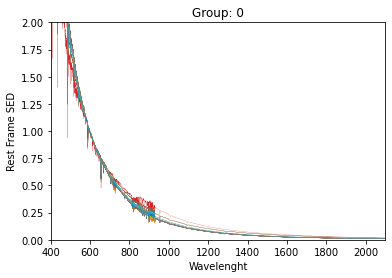

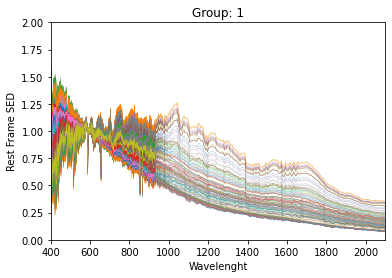

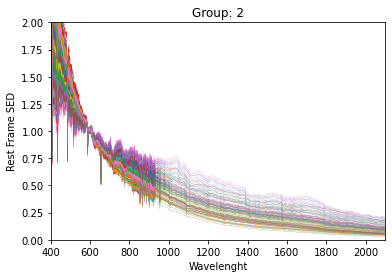

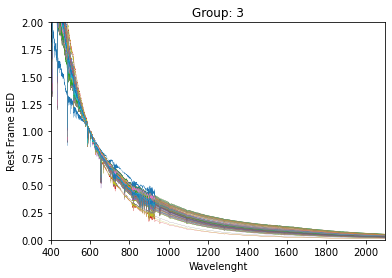

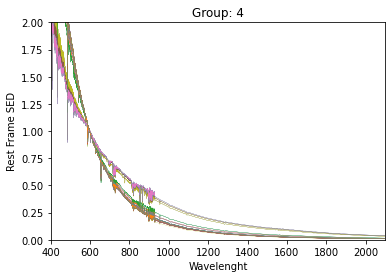

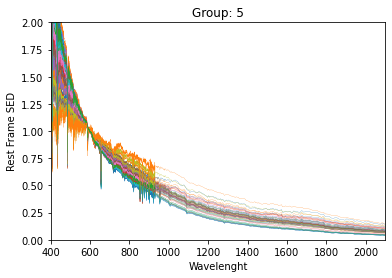

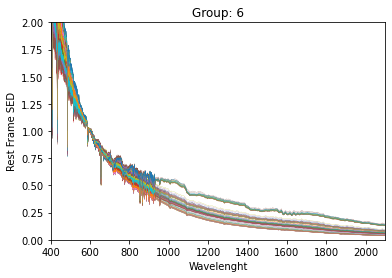

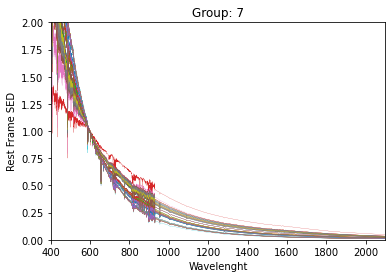

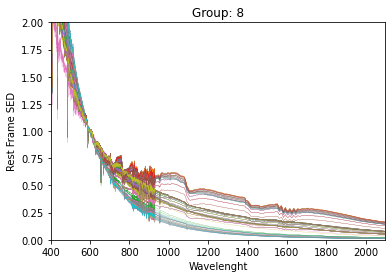

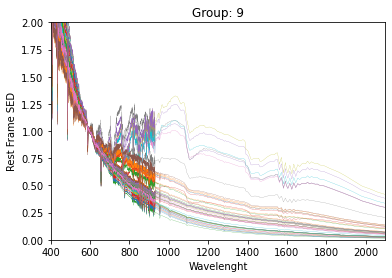

In [115]:
for i in range(10):
    for sed_name in groups[i]:
        f_s = sed_f_dict[sed_name]
        plt.plot(waves ,f_s /(f_s [3000]), lw = 0.2 )
        plt.xlim(400,2100)
        plt.ylim(0,2)
    plt.title('Group: ' + str(i))
    plt.xlabel ('Wavelenght')
    plt.ylabel ('Rest Frame SED')
    plt.show()

In [29]:
#'Inst.31E06.04Z.spec.gz' in groups[0], groups[0]

In [30]:
# group 7 = 20%, group 1 = 55%, group 2 = 25%,  group 5 = 40%,  
remove_seds = groups[1]
good_ids = []
for i in range(len(train_ids)):
    disk_name, bulge_name = disk_sednames[i], bulge_sednames[i]
    if disk_name in remove_seds or bulge_name in remove_seds:
        continue
    else:
        good_ids.append(i) 

In [2]:
pickle_in = open("Removed_SEDs/cosmodc2_10067_deep_55pcentSEDcut","wb")
roman_train_mags = pickle.dump(good_ids, pickle_in)
pickle_in.close()

In [5]:
#len(good_ids)/len(train_ids)

In [32]:
remove_seds = groups[2]
good_ids_test = []
for i in range(len(test_ids)):
    disk_name, bulge_name = disk_test_sednames[i], bulge_test_sednames[i]
    if disk_name in remove_seds or bulge_name in remove_seds:
        continue
    else:
        good_ids_test.append(i) 

In [3]:
#len(groups[2]), groups[2]

In [4]:
#len(good_ids_test)

In [190]:
pickle_in = open("Removed_SEDs/cosmodc2_10067_deep_25pcentSEDcut","wb")
roman_train_mags = pickle.dump(good_ids, pickle_in)
pickle_in.close()